# MNIST and CNN architecture

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# calling the dataset
from tensorflow.keras.datasets import mnist

# access the training and test data
(Xtr_raw, Ytr_raw), (Xte_raw, Yte_raw)= mnist.load_data()

(Xtr_raw.shape, Ytr_raw.shape), (Xte_raw.shape, Yte_raw.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

The reshape function changes the dimensions of the data to prepare it for input into the neural network. It reshapes the images into 4D dimensions with the size of (number of samples, image height, image width, number of channels). In MNIST, the dimensions of the images are (60000, 28, 28), which are reshaped to (60000, 1, 28, 28). This is necessary to match the input size of the neural network layers.

In [3]:
# data reformating - adding a channel dimension
Xtr_raw= np.expand_dims(Xtr_raw, 1) # Grayscale images have 1 channel
Xte_raw= np.expand_dims(Xte_raw, 1)

Xtr_raw.shape

(60000, 1, 28, 28)

# Data processing

Some datasets, like MNIST, require minimal processing, but real-world data is not always so straightforward.

If normalization is not performed, one of the issues that arises is convergence problems, which may result in the model converging slowly or not converging at all. There are various methods of normalization. These include Pixel-wise normalization (where each pixel of the image is normalized based on the mean and variance of similar pixels in the dataset), Local Contrast normalization (useful for images with local brightness variations, where each region of the image is normalized relative to similar regions in all data), Robust Scaling (which uses the median and interquartile range of the data for scaling, making it robust against outliers), and Unit Vector Scaling (where each row of the data is normalized in such a way that the sum of squares of its values equals one).

The Min-Max Scaling method is more suitable for data with a normal distribution or similar. When the data have a non-normal distribution, such as MNIST, the Z-score method is usually more useful because it normalizes the data based on the mean and variance.

In [4]:
# For the MNIST dataset, normalization may be useful but often not necessary.
# We will just subtract the mean image for centering (e.g., AlexNet)
# see https://www.youtube.com/watch?v=gYpoJMlgyXA

# convert data to float32
Xtr_raw= Xtr_raw.astype(np.float32)
Xte_raw= Xte_raw.astype(np.float32)

# calculate the mean of the training data
Xmean= np.mean(Xtr_raw)

# apply the centering to the training data
Xtr_raw -= Xmean

# apply the centering to the test data using the mean of the training data
Xte_raw -= Xmean

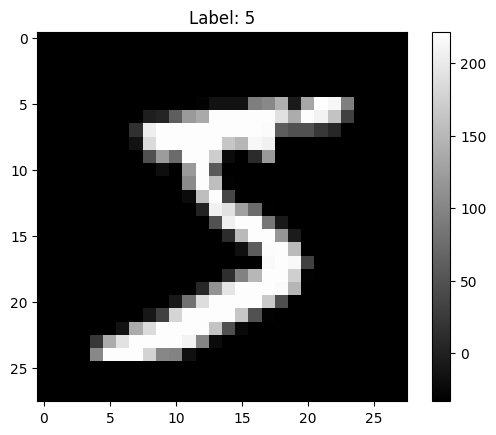

In [5]:
# rendering one example
plt.imshow(Xtr_raw[0][0], cmap='gray')
plt.colorbar()
plt.title(f'Label: {Ytr_raw[0]}')
plt.show()

In [6]:
# setting the device
device= 'cuda' if torch.cuda.is_available() else 'cpu'

# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)
Xte= torch.tensor(Xte_raw, requires_grad=True).to(device)
Yte= torch.tensor(Yte_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.to(torch.int64), num_classes=10).to(torch.float32)
Yte= F.one_hot(Yte.to(torch.int64), num_classes=10).to(torch.float32)

# creating a dev dataset from training data
tr_size= int(0.8*Xtr.shape[0])

Xdev= Xtr[tr_size:]
Ydev= Ytr[tr_size:]

Xtr= Xtr[:tr_size]
Ytr= Ytr[:tr_size]

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000, 10])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000, 10])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


# Architecture Design (Model Building)

Using PyTorch to create a modified, smaller version of AlexNet. This model has two general parts: the convolutional backbone and the densely connected head.

In [7]:
class Activation(nn.Module):
    """
    Activation functions implemented: relu, tanh.
    """

    def __init__(self, activation='relu') -> None:
        super(Activation, self).__init__()
        if 'relu' in activation:
            self.activ= nn.ReLU()
        else:
            self.activ= nn.Tanh()


    def forward(self, x):

        return self.activ(x)


In [8]:
class CNN_Hidden(nn.Module):
    """
    Implements one CNN hidden layer.
    """

    def __init__(self, in_chs, out_chs, kernels, max_pool, norm, activation, dropout) -> None:
        super(CNN_Hidden, self).__init__()
        self.conv_hn= nn.Conv2d(in_chs, out_chs, kernels) # Convolutional layer
        self.max_pool= nn.MaxPool2d(kernel_size=max_pool) # Max pooling layer
        self.norm= None
        if norm:
            self.norm= nn.BatchNorm2d(out_chs)            # Adding Batch Normalization layer
        self.activ= Activation(activation)
        self.dropout= None
        if dropout> 0.0:
            self.dropout= nn.Dropout(p=dropout)           # Dropout layer for regularization


    def forward(self, x):
        x= self.conv_hn(x)
        x= self.max_pool(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activ(x)
        if self.dropout is not None:
            x= self.dropout(x)

        return x



class Backbone(nn.Module):
    """
    Defining the CNN backbone.
    """

    def __init__(self, input_chs, output_chs, hidden_chs=[16,], kernels=3, max_pool=2,
                 norm=False, activation='relu', dropout=0.0) -> None:
        super(Backbone, self).__init__()
        if isinstance(hidden_chs, int):
            if hidden_chs== 0:
                raise Exception('hidden_chs cannot be zero')
            hidden_chs= [hidden_chs]
        n_hidden_layers= len(hidden_chs)

        if n_hidden_layers== 0:
            raise Exception('hidden_chs cannot be an empty list')

        self.conv_in= CNN_Hidden(input_chs, hidden_chs[0], kernels, max_pool, norm,
                                activation, dropout)

        if n_hidden_layers> 1:
            self.conv_hn= nn.Sequential(*[
                CNN_Hidden(d, hidden_chs[i+1], kernels, max_pool, norm, activation, dropout)
                for i, d in enumerate(hidden_chs[:-1])
            ])
        else: self.conv_hn= None

        self.conv_out= nn.Conv2d(hidden_chs[-1], output_chs, kernels)


    def forward(self, x):
        x= self.conv_in(x)
        if self.conv_hn is not None:
            x= self.conv_hn(x)
        x= self.conv_out(x)

        return torch.flatten(x, 1) # Flatten last layer to convert 2D matrix to a vector


In [9]:
class MLP_Hidden(nn.Module):
    """
    Implements one MLP hidden layer.
    """

    def __init__(self, in_dim, out_dim, norm, activation, dropout) -> None:
        super(MLP_Hidden, self).__init__()
        self.fc_hn= nn.Linear(in_dim, out_dim)  # Fully connected layers
        self.norm= None
        if norm:
            self.norm= nn.LayerNorm(out_dim)    # Adding Layer Normalization
        self.activ= Activation(activation)
        self.dropout= None
        if dropout> 0.0:
            self.dropout= nn.Dropout(p=dropout) # Dropout layer for regularization


    def forward(self, x):
        x= self.fc_hn(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activ(x)
        if self.dropout is not None:
            x= self.dropout(x)

        return x



class Head(nn.Module):
    """
    Defining the MLP Projection Head (for data classification).
    """

    def __init__(self, input_dim, n_classes=1, hidden_dim=[16,], norm=False,
                 activation='relu', dropout=0.0) -> None:
        super(Head, self).__init__()
        if isinstance(hidden_dim, int):
            if hidden_dim== 0:
                raise Exception('hidden_dim cannot be zero')
            hidden_dim= [hidden_dim]
        n_hidden_layers= len(hidden_dim)

        if n_hidden_layers== 0:
            raise Exception('hidden_dim cannot be an empty list')

        self.fc_in= MLP_Hidden(input_dim, hidden_dim[0], norm, activation, dropout)

        if n_hidden_layers> 1:
            self.fc_hn= nn.Sequential(*[
                MLP_Hidden(d, hidden_dim[i+1], norm, activation, dropout)
                for i, d in enumerate(hidden_dim[:-1])
            ])
        else: self.fc_hn= None

        self.fc_out= nn.Linear(hidden_dim[-1], n_classes)


    def forward(self, x):
        x= self.fc_in(x)
        if self.fc_hn is not None:
            x= self.fc_hn(x)
        x= self.fc_out(x)

        return F.log_softmax(x, dim=1) # Output layer with softmax activation for classification


In [10]:
class CNN_Model(nn.Module):
    """
    Defining the full model - Feature extractor backbone + classification (projection) head.
    """

    def __init__(self, input_chs, output_chs, hidden_chs=[16,], kernels=3, max_pool=2, # CNN
                       input_dim=1, n_classes=1, hidden_dim=[16,],                     # MLP
                       norm=False, activation='relu', dropout=0.0) -> None:
        super(CNN_Model, self).__init__()
        self.backbone= Backbone(
            input_chs, output_chs, hidden_chs, kernels, max_pool, norm, activation, dropout
        )
        self.head= Head(
            input_dim, n_classes, hidden_dim, norm, activation, dropout
        )


    def forward(self, x):
        x= self.backbone(x)
        x= self.head(x)

        return x


BatchNorm normalizes each feature within a batch of samples, while LayerNorm normalizes all features within each sample. Let's assume we have a two-dimensional input matrix, where the rows represent the batch and the columns represent the sample features. The target of Batch Normalization is a batch of samples (horizontal), and the target of Layer Normalization is a single sample (vertical).

For the field of computer vision, features depend on the statistical parameters between different samples, and **BatchNorm** is more effective. This is because it eliminates the size relationship between different features while preserving the size relationship between different samples.

In the field of NLP, **LayerNorm** is more appropriate. This is because the different features of a single sample are actually the variations in words over time, and the feature relationships within the sample are very close.

In [12]:
# ----- Backbone defs -----
input_chs= Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[32,64,]     # represents the number of filters used in each convolutional layer
output_chs= 64          # number of channels in the output
kernels=3               # represents the dimensions of the kernel or filter, which collects information from the images
max_pool=2              # performs pooling operations on the images
# ----- Head defs -----
input_dim= 576
hidden_dim=[64,32,]     # dense (fully connected) layers
n_classes=10            # digits from 0 to 9
# ----- general defs -----
norm=True
activation='relu'
dropout=0.1


model= CNN_Model(input_chs, output_chs, hidden_chs, kernels, max_pool,
                 input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model

Number of parameters: 95466


CNN_Model(
  (backbone): Backbone(
    (conv_in): CNN_Hidden(
      (conv_hn): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv_hn): Sequential(
      (0): CNN_Hidden(
        (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (conv_out): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Head(
    (fc_in): MLP_Hidden(
      (fc_hn): Linear(in

# Training Phase

After constructing the model and its layers with the CNN architecture, the next step is to set the loss function, optimizer, and select evaluation metrics. In machine learning, the loss function represents the difference between the model's output and the actual values. In all tasks, whether in the real world or for solving deep learning problems, one of the most important tasks is to minimize the error.

The optimizer is responsible for optimizing and updating the model's weights (W), adjusting them in a way that minimizes the loss function. Optimizers come in various types such as Adam, SGD, and RMSprop, and selecting the right one for your specific task can help improve the model's performance.

The learning rate determines how small the training steps should be to reach the optimal point. Selecting an appropriate learning rate is crucial in training a model.

Typically, when fitting the model, the first thing we do is specify the number of epochs. In each epoch, the model sees the entire training dataset once to learn complex patterns in the data. Naturally, the higher the number of epochs, the better the model learns because it can see more data, but if it's too high, it may lead to overfitting. In other words, because the model overly converges to the training data, it fails to generalize to new data. In other words, the model simply memorizes the data.

Determining the batch size specifies how many data samples are shown to the model in each epoch. Finding the optimal batch size has a significant impact on the speed and quality of model training. Naturally, a larger batch size is preferable for better performance. However, due to memory constraints, especially in large-scale projects, this may not always be feasible. In diverse datasets, a larger batch size may lead to a loss of model adaptation to the data, resulting in overfitting or underfitting. To prevent this, we can find the best batch size through trial and error or by employing systematic and principled methods such as Grid Search or Validation Data-based approaches.

In [11]:
def supervised_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches=True,
                        early_stop:bool=False, cutoff=1e-9, verbose:bool=False):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        batch_size= 64
        epoch_size= round(Xtr.shape[0]/ batch_size)-1
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.CrossEntropyLoss().to(device)

    # for early stoping
    cutoff_ratio= cutoff
    patience= 5
    patience_count= 0
    previous_loss= 1e10

    # tracking data
    train_hist= []
    batch_loss= []
    dev_hist= []

    # training loop
    for epoch in tqdm(range(epochs)):
        # iterating over all batches
        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[(i * batch_size) : ((i+1) * batch_size)]
            Ymb= Ytr[(i * batch_size) : ((i+1) * batch_size)]

            # --- forward pass and loss ---
            model.train(True)
            y_pred= model(Xmb)
            loss_tr= loss_fn(y_pred, Ymb)
            batch_loss.append(loss_tr.item())

            # --- backward pass ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))
        batch_loss= []

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                y_pred= model(Xdev)
                loss_dev= loss_fn(y_pred, Ydev)

        dev_hist.append(loss_dev.item())


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff_ratio):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    # final evaluation on the test set
    model.train(False)
    with torch.no_grad():
        y_pred= model(Xte)
        #loss_test= loss_fn(y_pred, Yte)
        test_acc= (y_pred.argmax(dim=1)== Yte.argmax(dim=1)).sum().item()/ Yte.shape[0]


    return train_hist, dev_hist, test_acc


In [13]:
train_hist, dev_hist, test_acc= supervised_training(model, learning_rate=1e-3, epochs=10,
                                                    eval_interval=2, batches=True,
                                                    early_stop=True, cutoff=1e-6)

100%|██████████| 10/10 [26:38<00:00, 159.88s/it]


If there isn't much difference between the training accuracy and validation accuracy, meaning they are closer to each other, it indicates that the model hasn't overfit. However, if there is a significant difference, or if the validation accuracy starts decreasing while the training accuracy increases, it's suspicious for overfitting. The accuracy lines should be smoother with fewer fluctuations. The presence of more fluctuations indicates instability in the model's performance, which could be a sign of overfitting.

If the Training Accuracy is continuously decreasing while the Validation Accuracy starts to increase or remains stable, this indicates overfitting. Conversely, if both training and validation accuracies consistently decrease or remain stable at similar levels, it indicates that the model has effectively learned. Ideally, we aim to steadily increase both Training and Validation accuracies or stabilize them at similar levels.

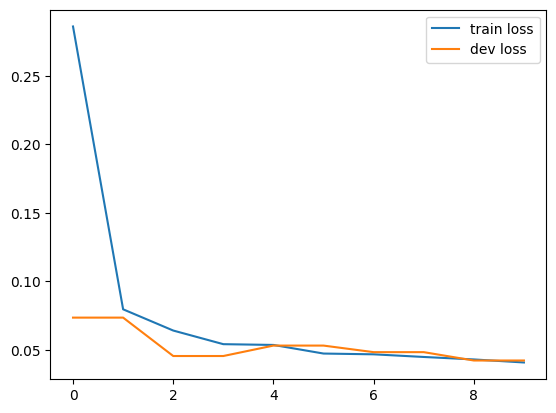

Test accuracy: 0.9884


In [14]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

In [15]:
# Small version

# ----- Backbone defs -----
input_chs= Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[16,16,]     # represents the number of filters used in each convolutional layer
output_chs= 32          # number of channels in the output
kernels=3               # represents the dimensions of the kernel or filter, which collects information from the images
max_pool=2              # performs pooling operations on the images
# ----- Head defs -----
input_dim= 288
hidden_dim=[32,16,]     # dense (fully connected) layers
n_classes=10            # digits from 0 to 9
# ----- general defs -----
norm=True
activation='relu'
dropout=0.1


model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, max_pool,
                  input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

total_params= sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model2

Number of parameters: 17226


CNN_Model(
  (backbone): Backbone(
    (conv_in): CNN_Hidden(
      (conv_hn): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv_hn): Sequential(
      (0): CNN_Hidden(
        (conv_hn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (conv_out): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Head(
    (fc_in): MLP_Hidden(
      (fc_hn): Linear(in

In [16]:
train_hist, dev_hist, test_acc= supervised_training(model2, learning_rate=1e-3, epochs=10,
                                                    eval_interval=2, batches=True,
                                                    early_stop=True, cutoff=1e-6)

100%|██████████| 10/10 [26:01<00:00, 156.17s/it]


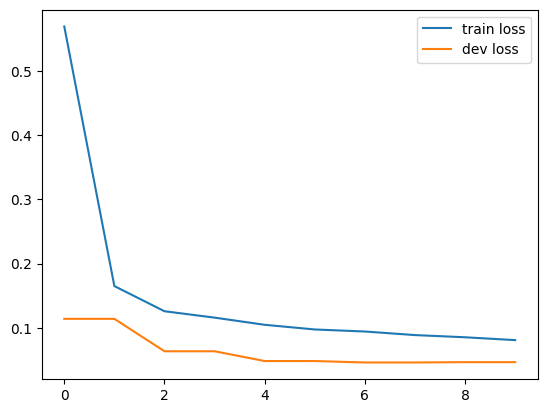

Test accuracy: 0.9884


In [17]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

In [ ]:
# https://ai.gopubby.com/step-by-step-guide-to-building-an-artificial-neural-network-and-observing-how-overfitting-occurs-84961f96c7e8